## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project evaluates the results of an A/B test run by an e-commerce website. The goal is to the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries:

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# setting a seed to ensure replicability
random.seed(42)

Read in the `ab_data.csv` data and store it in `df`.
Looking at the first few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Finding the number of rows in the dataset:

In [3]:
df.shape[0]

294478

The number of unique users in the dataset:

In [4]:
df.user_id.nunique()

290584

To check if any cleaning is required, we look at the number of times the `new_page` and `treatment` don't line up. The treatment group should have been presented the new page, while the control group should have used the old page. But we see that this isn't always the case:

In [5]:
df.groupby(['group', 'landing_page']).count().user_id

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

In [6]:
filter =(
    ((df.group == 'control') & (df.landing_page == 'new_page'))
    |
    ((df.group == 'treatment') & (df.landing_page == 'old_page'))
)

filter.sum()

3893

Also, checking for missing values:

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this user received the new or old page. Given the small proportion of these entries, we can remove them.

In [8]:
df2 = df.drop(df[filter].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Checking how many unique **user_id**s are in the new data frame:

In [10]:
df2.user_id.nunique()

290584

See if there are any duplicates:

In [11]:
df2.duplicated('user_id').sum()

1

What is the row information for the repeat **user_id**? 

In [12]:
dup_user_id = df2.user_id.value_counts().idxmax()
df2[df2.user_id == dup_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, while keeping the same name for the dataframe.

In [13]:
df2= df2.drop_duplicates(subset='user_id', inplace=False)

With the cleaning step out of the way, we can start answering questions regarding the dataset.
<br>First, to calculate the proportion of users converted (i.e. users who decide to pay for the company's product):

In [14]:
(df2.converted == 1).mean()

0.11959708724499628

This represents the probability of an individual converting regardless of the page they receive.

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = (
    ((df2.group == 'control') & (df2.converted == 1))
    .mean()
    /
    (df2.group == 'control').mean()
)

p_control

0.12038630450046119

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = (
    ((df2.group == 'treatment') & (df2.converted == 1))
    .mean()
    /
    (df2.group == 'treatment').mean()
)

p_treatment

0.11880806551510564

What is the probability that an individual received the new page?

In [17]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

**There seems to be evidence that, on average, users from the 'control' group (who see the old page) have a slightly higher probability of converting than the 'treatment' group (those who visit the new page). Further tests would be required to confirm reliability.**

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, one could technically run a hypothesis test continuously as each observation came in. However, then the hard question is whether to stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run in order to decide that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.  

For now, we will consider to make the decision based on all the data provided.  If we want to assume that the old page is better, unless the new page proves to be definitely better (at a Type I error rate of 5%), we can state our hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages:

Null: **$p_{new}$** - **$p_{old}$** <= 0
<br>Alternative: **$p_{new}$** - **$p_{old}$** > 0

We assuming under the null hypothesis, that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page, and that they are equal. We'll use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

We perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null?

In [19]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

What is $n_{new}$?

In [20]:
n_new = (df2.landing_page == 'new_page').sum()
n_new

145310

What is $n_{old}$?

In [21]:
n_old = (df2.landing_page == 'old_page').sum()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null, and store these $n_{new}$ 1's and 0's in **new_page_converted**:

In [22]:
new_page_converted = np.random.choice([0,1],
                                      size=n_new,
                                      replace=True,
                                      p=[1-p_new, p_new])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null, and store these $n_{old}$ 1's and 0's in **old_page_converted**:

In [23]:
old_page_converted = np.random.choice([0,1],
                                      size=n_old,
                                      replace=True,
                                      p=[1-p_old, p_old])

Finding $p_{new}$ - $p_{old}$ for the simulated values:

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0014334048761795448

Simulate 10,000 $p_{new}$ - $p_{old}$ values by repeating the process above, and store the values in **p_diffs**:

In [25]:
p_diffs = []
for _ in range(10_000):
    new_page_converted = np.random.choice([0,1],
                                      size=n_new,
                                      replace=True,
                                      p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1],
                                      size=n_old,
                                      replace=True,
                                      p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plot a histogram of the **p_diffs**:

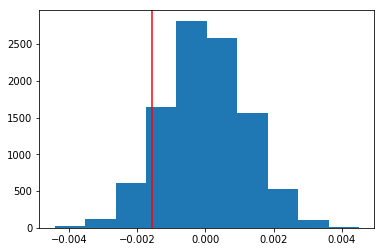

In [26]:
plt.hist(p_diffs);
plt.axvline(p_treatment - p_control, color='r')

What proportion of the **p_diffs** are greater than the actual difference observed in our sample **ab_data.csv**?

In [27]:
(p_diffs > (p_treatment - p_control)).mean()

0.9057

**This number represents the proportion of values in the null distribution that would be in favour of the alternative. Or in other words, the chance that a normal distribution based on the null hypothesis would *capture* a value that is equal to or greater than our sampling distribution statistic.
In scientific studies this is known as the **p-value**. 
It is thus very likely that our observed difference came from the null, so given our Type I error threshold of 5%, we do not have sufficient evidence to reject the null. This means that users visiting the new page do not have a higher conversion rate when compared to the old page, and that this result is statistically significant.**

As an alternative, we could also use a specialized library to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively:

In [28]:
import statsmodels.api as sm

convert_old = ((df2.landing_page == 'old_page') & (df2.converted == 1)).sum()
convert_new = ((df2.landing_page == 'new_page') & (df2.converted == 1)).sum()
n_old = (df2.landing_page == 'old_page').sum()
n_new = (df2.landing_page == 'new_page').sum()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Now using `stats.proportions_ztest` to compute the test statistic and p-value:

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [30]:
# what is our critical value at 95% confidence

from scipy.stats import norm

norm.ppf(0.05)

-1.6448536269514729

**Here we checked if the z-score exceeds the critical value of -1.64 in negative direction. Since our z-score of -1.31 does not exceed -1.64 in the negative, we fail to reject the null hypothesis. The conclusion therefore agrees with the one above, with the same statistical significance given by the p-value (0.906 and 0.905 respectively).**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will check that the result acheived in the previous A/B test can also be acheived by performing regression.<br>
Since each row is either a conversion or no conversion, we'll use **logistic regression** to best predict one of the two alternatives.<br>
The goal is to use `statsmodels` to fit the regression model, and check if there is a significant difference in conversion based on which page a customer receives.<br><br>
First we need to create a colun for the intercept, and create a dummy variable column for the page each user received.<br>
Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**:

In [31]:
df2['intercept'] = 1
df2['ab_page'] = np.array(df2.group == 'treatment')*1

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Instantiate the model, and fit the model using the two columns created above to predict whether or not an individual converts.

In [33]:
logit_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:24:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value from the logistic regression associated with 'ab_page' is 0.190. The difference from the p-value in the hypothesis testing could be explained by the following: 
<br>While in hypothesis testing we compared the difference in mean conversion rate for the two groups, with the null hypothesis being that the difference was less than or equal to zero, here we are comparing how well can being in one group or another determine the outcome of the dependent variable, with a null hypothesis being that the predicted conversion outcomes are no closer to the actual outcomes than we would expect by chance. <br><br>

**How about considering other things that might influence whether or not an individual converts?**

Adding additional factors in the regression would help us better understand how multiple variables might influence the response when considered together. However, the disadvantage would be the additional risks introduced by each additional variable, such as risks of non-liniarity, outliers or risk of coliniarity.

Along with testing if the conversion rate changes for different pages, we can also look at which *country* a user lives in. For this, we will use the **countries.csv** dataset and merge together the two datasets on the approporiate rows.

In [35]:
# load countries dataframe
countries_df = pd.read_csv('countries.csv')

countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
# check consistency
countries_df.user_id.nunique(), countries_df.country.value_counts()

(290584, US    203619
 UK     72466
 CA     14499
 Name: country, dtype: int64)

In [37]:
# joining on 'user_id' and save the new view
joined_df = countries_df.set_index('user_id').join(df2.set_index('user_id'))

# create dummy variables
joined_df[['CA', 'UK']] = pd.get_dummies(joined_df.country)[['CA', 'UK']]

joined_df.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [38]:
# fitting the model to investigate impact of 'country'

logit_mod = sm.Logit(joined_df.converted, joined_df[['intercept', 'CA', 'UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        12:24:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [39]:
# Exponentiating each of the coefficients from the dummy variables will give us the multiplicative change in the odds:

np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

In [40]:
# get the reciprocal for 'CA'
1 / np.exp(-0.0408)

1.0416437559600236

**High p-values suggest that the country variable do not seem to be significant in relation to the response variable ('converted').
<br>The odds for a user to convert don't appear to change much based on their country. For any of the countries, all else being equal, there isn't much change in conversion when compared to the base ('US').**

We can now look at an interaction between page and country to see if there significant effects on conversion.

In [41]:
logit_mod = sm.Logit(joined_df.converted, joined_df[['intercept', 'ab_page', 'CA', 'UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        12:24:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [42]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

In [43]:
1/ np.exp(-0.0149), 1/np.exp(-0.0408)

(1.0150115583846535, 1.0416437559600236)

**The result suggests that even when analized together, the page and the country do not make much difference in determining whether a user converts or not. Looking at the coefficients, we could however notice that, being from Canada (and landing on the new page) would make a user 1.04 less likely to convert then a user from US who lands on the new page.**